# XGBoost CDR Prediction Analysis

This notebook implements rigorous XGBoost methodology for CDR prediction:
1. **Age-only baselines** for both binary and multiclass models
2. **CV-selected hyperparameters** using proper nested cross-validation
3. **Calibration curves** for clinical deployment readiness
4. **Feature importance analysis** leveraging XGBoost's built-in capabilities
5. **SHAP values** for model interpretability
6. **Early stopping** to prevent overfitting

## 1. Data Loading and Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, cohen_kappa_score, log_loss
)
from sklearn.calibration import calibration_curve, CalibrationDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.0.5


In [2]:
# Load and merge data
df = pd.read_csv('oasis_cross-sectional.csv')
df = df[~df['ID'].str.contains('_MR2', na=False)]  # Baseline scans only
df = df.drop(columns=['Educ', 'SES', 'MMSE', 'eTIV', 'Delay', 'Hand'])

mri_df = pd.read_csv('oasis_roi_volumes.tsv', sep='\t')
df = df.merge(mri_df, left_on='ID', right_on='subject_id', how='inner')
df = df.drop(columns=['subject_id'])

# Get ROI columns
roi_columns = [col for col in df.columns if 'lh_' in col or 'rh_' in col]

# Scale ROI volumes by ASF
for col in roi_columns:
    df[col] = df[col] * df['ASF']

print(f"Dataset shape: {df.shape}")
print(f"\nCDR distribution:")
print(df['CDR'].value_counts().sort_index())

Dataset shape: (405, 16)

CDR distribution:
CDR
0.0    312
0.5     68
1.0     23
2.0      2
Name: count, dtype: int64


In [3]:
# Feature engineering: Create brain volume ratios
# These ratios may capture structural changes better than absolute volumes

# Hippocampal asymmetry (left/right ratio)
df['hippocampus_asymmetry'] = df['lh_hippocampus'] / (df['rh_hippocampus'] + 1e-6)

# Entorhinal asymmetry
df['entorhinal_asymmetry'] = df['lh_entorhinal'] / (df['rh_entorhinal'] + 1e-6)

# Total hippocampal volume
df['total_hippocampus'] = df['lh_hippocampus'] + df['rh_hippocampus']

# Total entorhinal volume
df['total_entorhinal'] = df['lh_entorhinal'] + df['rh_entorhinal']

# Hippocampus to whole brain ratio (normalized)
df['hippocampus_to_brain_ratio'] = df['total_hippocampus'] / (df['nWBV'] * 1e6)

# Ventricular expansion (larger ventricles = more atrophy)
df['total_ventricles'] = df['lh_lateral_ventricle'] + df['rh_lateral_ventricle']
df['ventricle_to_brain_ratio'] = df['total_ventricles'] / (df['nWBV'] * 1e6)

print(f"\nAdded ratio features:")
ratio_features = [
    'hippocampus_asymmetry', 'entorhinal_asymmetry',
    'total_hippocampus', 'total_entorhinal',
    'hippocampus_to_brain_ratio', 'total_ventricles',
    'ventricle_to_brain_ratio'
]
print(ratio_features)


Added ratio features:
['hippocampus_asymmetry', 'entorhinal_asymmetry', 'total_hippocampus', 'total_entorhinal', 'hippocampus_to_brain_ratio', 'total_ventricles', 'ventricle_to_brain_ratio']


In [4]:
# Create target variables
df['CDR_binary'] = (df['CDR'] > 0).astype(int)

# Fix multiclass: Convert to integer labels
df['CDR_multiclass'] = df['CDR'].copy()
df.loc[df['CDR'] >= 1, 'CDR_multiclass'] = 1.0  # Collapse CDR ≥1
# Convert to integer categorical
cdr_map = {0.0: 0, 0.5: 1, 1.0: 2}
df['CDR_multiclass'] = df['CDR_multiclass'].map(cdr_map)

print(f"Binary CDR distribution:")
print(df['CDR_binary'].value_counts())
print(f"\nMulticlass CDR distribution:")
print(df['CDR_multiclass'].value_counts().sort_index())

Binary CDR distribution:
CDR_binary
0    312
1     93
Name: count, dtype: int64

Multiclass CDR distribution:
CDR_multiclass
0    312
1     68
2     25
Name: count, dtype: int64


## 2. Binary Classification: CDR=0 vs CDR>0

In [5]:
# Prepare features for binary classification
X_binary = df.drop(columns=['ID', 'CDR', 'CDR_binary', 'CDR_multiclass'])
X_binary['M/F'] = (X_binary['M/F'] == 'M').astype(int)
y_binary = df['CDR_binary']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Test set CDR=0: {sum(y_test==0)}, CDR>0: {sum(y_test==1)}")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print(f"\nClass imbalance ratio (scale_pos_weight): {scale_pos_weight:.2f}")

Training set: 324 samples
Test set: 81 samples
Test set CDR=0: 62, CDR>0: 19

Class imbalance ratio (scale_pos_weight): 3.38


In [6]:
def nested_cv_xgboost(X_train, y_train, X_test, y_test, model_name, param_grid, 
                      task='binary', scale_pos_weight=None):
    """
    Perform nested cross-validation with XGBoost and proper hyperparameter selection.
    Returns: best_params, cv_scores, test_predictions, test_probabilities, trained_model
    """
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scoring = 'roc_auc' if task == 'binary' else 'accuracy'
    
    outer_scores = []
    best_params_list = []
    
    print(f"\n{'='*60}")
    print(f"NESTED CV: {model_name}")
    print(f"{'='*60}")
    
    for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # XGBoost doesn't require scaling but we'll do it for consistency
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Set up base model
        if task == 'binary':
            base_model = xgb.XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42,
                early_stopping_rounds=10,
                enable_categorical=False
            )
        else:
            base_model = xgb.XGBClassifier(
                objective='multi:softprob',
                eval_metric='mlogloss',
                random_state=42,
                early_stopping_rounds=10,
                enable_categorical=False
            )
        
        # Inner CV: GridSearch
        grid_search = GridSearchCV(
            base_model,
            param_grid=param_grid,
            cv=inner_cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(
            X_train_scaled, y_train_fold,
            eval_set=[(X_val_scaled, y_val_fold)],
            verbose=False
        )
        
        best_model = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)
        
        # Evaluate
        if task == 'binary':
            y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
            score = roc_auc_score(y_val_fold, y_val_proba)
        else:
            y_val_pred = best_model.predict(X_val_scaled)
            score = accuracy_score(y_val_fold, y_val_pred)
        
        outer_scores.append(score)
        print(f"Fold {fold_idx}: {scoring}={score:.3f}, params={grid_search.best_params_}")
    
    # Most common hyperparameters
    final_params = {}
    for param in param_grid.keys():
        values = [p[param] for p in best_params_list]
        final_params[param] = Counter(values).most_common(1)[0][0]
    
    print(f"\nCV {scoring}: {np.mean(outer_scores):.3f} ± {np.std(outer_scores):.3f}")
    print(f"Selected hyperparameters: {final_params}")
    
    # Train final model on full training set
    scaler_final = StandardScaler()
    X_train_scaled = scaler_final.fit_transform(X_train)
    X_test_scaled = scaler_final.transform(X_test)
    
    if task == 'binary':
        final_model = xgb.XGBClassifier(
            **final_params,
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            early_stopping_rounds=10,
            enable_categorical=False
        )
    else:
        final_model = xgb.XGBClassifier(
            **final_params,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            early_stopping_rounds=10,
            enable_categorical=False
        )
    
    final_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )
    
    # Test predictions
    y_test_pred = final_model.predict(X_test_scaled)
    y_test_proba = final_model.predict_proba(X_test_scaled)
    
    return final_params, outer_scores, y_test_pred, y_test_proba, final_model, scaler_final

In [7]:
# Full model with brain features + ratios
param_grid_full = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

(
    best_params_full,
    cv_scores_full,
    y_test_pred_full,
    y_test_proba_full,
    model_full,
    scaler_full
) = nested_cv_xgboost(
    X_train, y_train, X_test, y_test,
    "Full Model (Brain Features + Ratios)",
    param_grid_full,
    task='binary',
    scale_pos_weight=scale_pos_weight
)

test_auc_full = roc_auc_score(y_test, y_test_proba_full[:, 1])
print(f"\nTest AUC: {test_auc_full:.3f}")
print(f"Test Log Loss: {log_loss(y_test, y_test_proba_full):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_full, target_names=['CDR=0', 'CDR>0']))


NESTED CV: Full Model (Brain Features + Ratios)
Fold 1: roc_auc=0.929, params={'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}
Fold 2: roc_auc=0.916, params={'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 1.0}
Fold 3: roc_auc=0.959, params={'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}
Fold 4: roc_auc=0.927, params={'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}
Fold 5: roc_auc=0.896, params={'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}

CV roc_auc: 0.925 ± 0.020
Selected hyperparameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight':

In [8]:
# Age-only baseline
X_train_age = X_train[['Age']]
X_test_age = X_test[['Age']]

param_grid_age = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3]
}

(
    best_params_age,
    cv_scores_age,
    y_test_pred_age,
    y_test_proba_age,
    model_age,
    scaler_age
) = nested_cv_xgboost(
    X_train_age, y_train, X_test_age, y_test,
    "Age-Only Baseline",
    param_grid_age,
    task='binary',
    scale_pos_weight=scale_pos_weight
)

test_auc_age = roc_auc_score(y_test, y_test_proba_age[:, 1])
print(f"\nTest AUC: {test_auc_age:.3f}")
print(f"Test Log Loss: {log_loss(y_test, y_test_proba_age):.3f}")


NESTED CV: Age-Only Baseline
Fold 1: roc_auc=0.753, params={'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50}
Fold 2: roc_auc=0.829, params={'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50}
Fold 3: roc_auc=0.868, params={'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 4: roc_auc=0.806, params={'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50}
Fold 5: roc_auc=0.862, params={'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50}

CV roc_auc: 0.823 ± 0.042
Selected hyperparameters: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.01, 'min_child_weight': 3}

Test AUC: 0.895
Test Log Loss: 0.512


In [9]:
# Binary classification comparison
print("\n" + "="*60)
print("BINARY CLASSIFICATION COMPARISON")
print("="*60)
print(f"\nFull Model:")
print(f"  CV AUC:   {np.mean(cv_scores_full):.3f} ± {np.std(cv_scores_full):.3f}")
print(f"  Test AUC: {test_auc_full:.3f}")
print(f"  Params:   {best_params_full}")

print(f"\nAge-Only Baseline:")
print(f"  CV AUC:   {np.mean(cv_scores_age):.3f} ± {np.std(cv_scores_age):.3f}")
print(f"  Test AUC: {test_auc_age:.3f}")
print(f"  Params:   {best_params_age}")

auc_improvement = test_auc_full - test_auc_age
rel_improvement = (auc_improvement / test_auc_age) * 100

print(f"\n📊 Brain features add: {auc_improvement:+.3f} AUC points ({rel_improvement:+.1f}% improvement)")

if auc_improvement > 0.05:
    print("✅ Brain volume ratios provide meaningful improvement!")
elif auc_improvement > 0.02:
    print("⚠️  Brain features provide modest improvement (2-5% range)")
else:
    print("⚠️  Brain features add minimal value over age alone")


BINARY CLASSIFICATION COMPARISON

Full Model:
  CV AUC:   0.925 ± 0.020
  Test AUC: 0.924
  Params:   {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3}

Age-Only Baseline:
  CV AUC:   0.823 ± 0.042
  Test AUC: 0.895
  Params:   {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.01, 'min_child_weight': 3}

📊 Brain features add: +0.028 AUC points (+3.2% improvement)
⚠️  Brain features provide modest improvement (2-5% range)


### Feature Importance Analysis


Top 15 Most Important Features:
                   feature  importance
            lh_hippocampus    0.261063
                      nWBV    0.107565
                       Age    0.067372
        rh_parahippocampal    0.055556
               rh_thalamus    0.051604
            rh_hippocampus    0.051266
hippocampus_to_brain_ratio    0.050329
               lh_thalamus    0.046483
         total_hippocampus    0.041259
          total_ventricles    0.033573
                       M/F    0.031013
          total_entorhinal    0.029798
      rh_lateral_ventricle    0.026058
             lh_entorhinal    0.023064
  ventricle_to_brain_ratio    0.022257


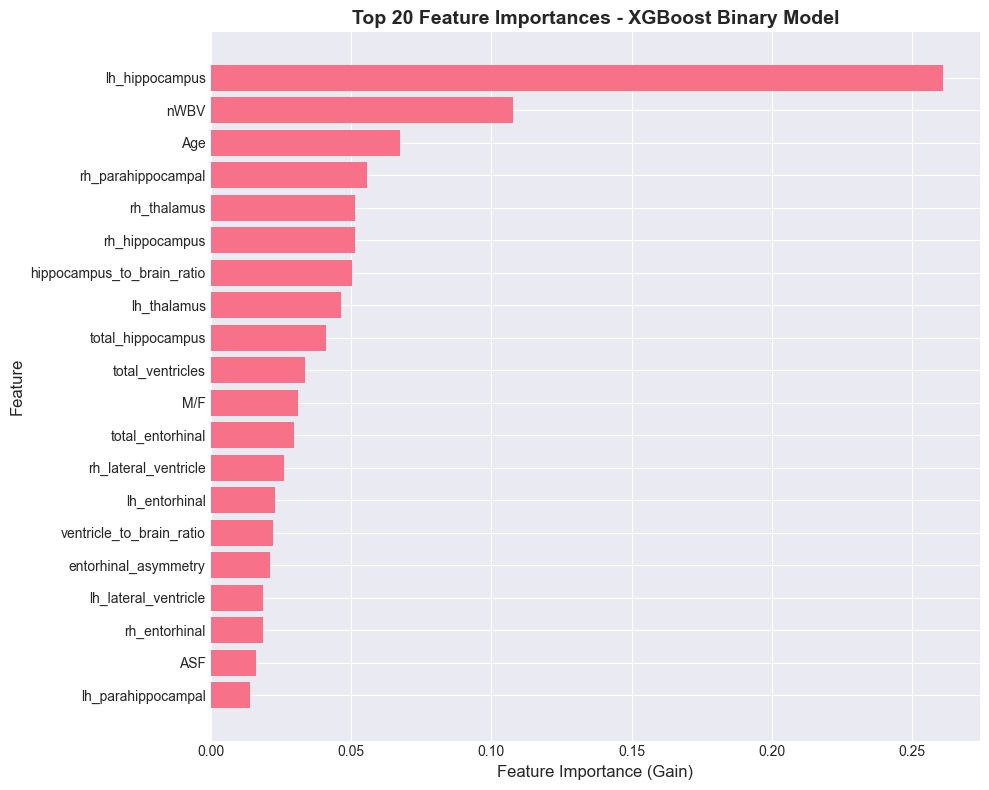

In [10]:
# Feature importance for full model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_full.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importances - XGBoost Binary Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Calibration Analysis (Clinical Deployment Requirement)

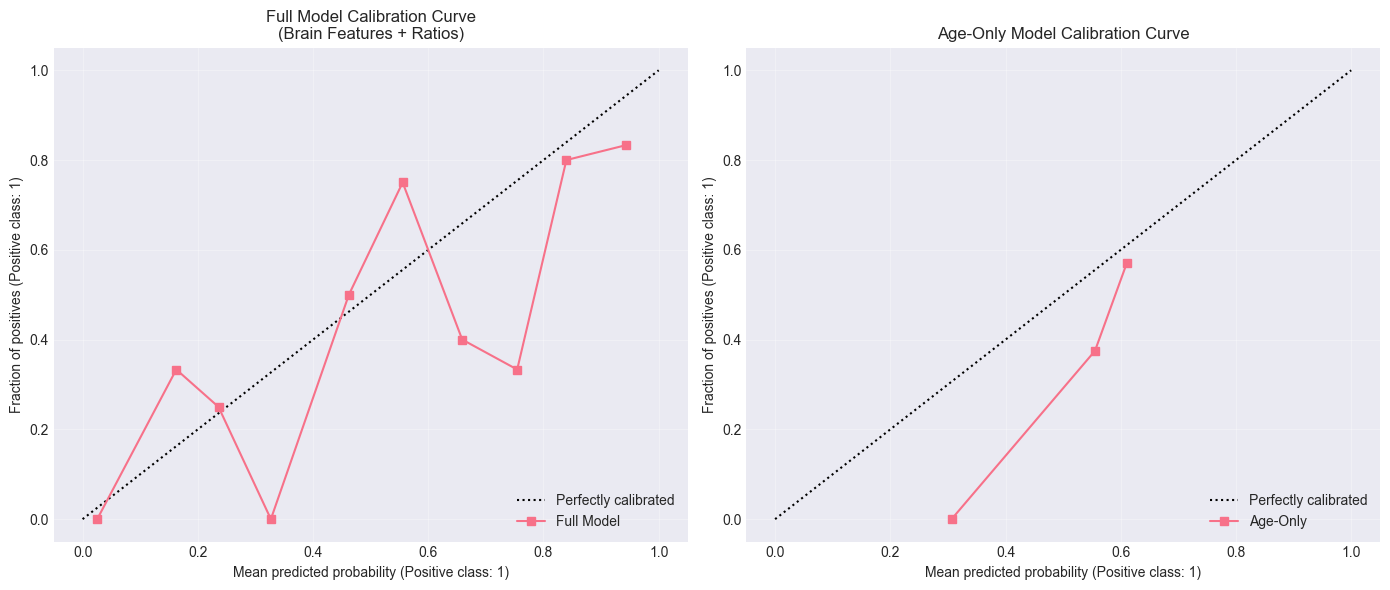


Calibration Interpretation:
- Points near diagonal = well-calibrated predictions
- Above diagonal = underconfident (actual rate > predicted)
- Below diagonal = overconfident (actual rate < predicted)

For clinical deployment, calibration is critical:
- Predicted probabilities should match true risk rates
- Enables informed decision-making for patient care


In [11]:
# Calibration curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full model calibration
CalibrationDisplay.from_predictions(
    y_test, y_test_proba_full[:, 1],
    n_bins=10,
    ax=axes[0],
    name='Full Model'
)
axes[0].set_title('Full Model Calibration Curve\n(Brain Features + Ratios)', fontsize=12)
axes[0].grid(alpha=0.3)

# Age-only calibration
CalibrationDisplay.from_predictions(
    y_test, y_test_proba_age[:, 1],
    n_bins=10,
    ax=axes[1],
    name='Age-Only'
)
axes[1].set_title('Age-Only Model Calibration Curve', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCalibration Interpretation:")
print("- Points near diagonal = well-calibrated predictions")
print("- Above diagonal = underconfident (actual rate > predicted)")
print("- Below diagonal = overconfident (actual rate < predicted)")
print("\nFor clinical deployment, calibration is critical:")
print("- Predicted probabilities should match true risk rates")
print("- Enables informed decision-making for patient care")

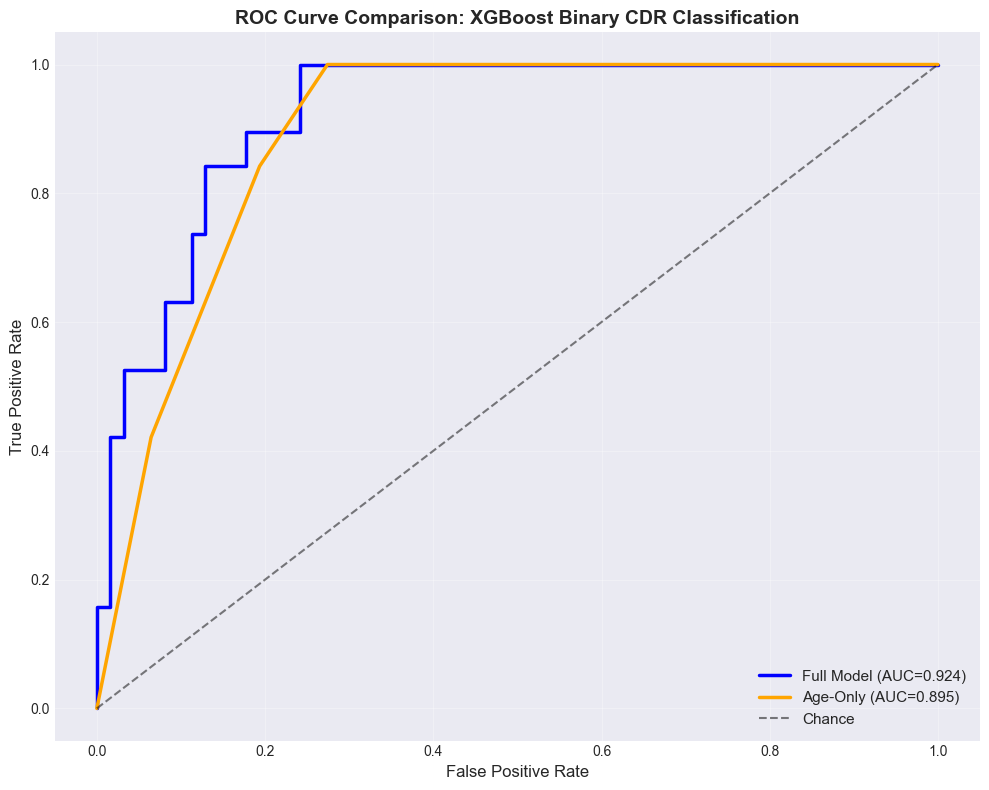

In [12]:
# ROC Comparison
plt.figure(figsize=(10, 8))

# Full model ROC
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_proba_full[:, 1])
plt.plot(fpr_full, tpr_full, linewidth=2.5, 
         label=f'Full Model (AUC={test_auc_full:.3f})', color='blue')

# Age-only ROC
fpr_age, tpr_age, _ = roc_curve(y_test, y_test_proba_age[:, 1])
plt.plot(fpr_age, tpr_age, linewidth=2.5, 
         label=f'Age-Only (AUC={test_auc_age:.3f})', color='orange')

# Chance line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Chance', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: XGBoost Binary CDR Classification', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Multiclass Classification: CDR Severity (0 vs 0.5 vs 1+)

In [13]:
# Prepare features for multiclass
X_multi = df.drop(columns=['ID', 'CDR', 'CDR_binary', 'CDR_multiclass'])
X_multi['M/F'] = (X_multi['M/F'] == 'M').astype(int)
y_multi = df['CDR_multiclass']

# Train/test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

print(f"Multiclass distribution in test set:")
class_names = {0: 'CDR=0', 1: 'CDR=0.5', 2: 'CDR≥1'}
for i in range(3):
    count = (y_test_m == i).sum()
    print(f"  {class_names[i]}: {count}")

Multiclass distribution in test set:
  CDR=0: 62
  CDR=0.5: 14
  CDR≥1: 5


In [14]:
# Full model multiclass
param_grid_multi = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

(
    best_params_multi,
    cv_scores_multi,
    y_test_pred_multi,
    y_test_proba_multi,
    model_multi,
    scaler_multi
) = nested_cv_xgboost(
    X_train_m, y_train_m, X_test_m, y_test_m,
    "Full Model (Multiclass)",
    param_grid_multi,
    task='multiclass'
)

test_acc_multi = accuracy_score(y_test_m, y_test_pred_multi)
test_kappa_multi = cohen_kappa_score(y_test_m, y_test_pred_multi, weights='quadratic')

print(f"\nTest Accuracy: {test_acc_multi:.3f}")
print(f"Test Weighted Kappa: {test_kappa_multi:.3f}")
print(f"Test Log Loss: {log_loss(y_test_m, y_test_proba_multi):.3f}")
print("\nClassification Report:")
print(classification_report(y_test_m, y_test_pred_multi, 
                          target_names=['CDR=0', 'CDR=0.5', 'CDR≥1']))


NESTED CV: Full Model (Multiclass)
Fold 1: accuracy=0.815, params={'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Fold 2: accuracy=0.785, params={'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 1.0}
Fold 3: accuracy=0.800, params={'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}
Fold 4: accuracy=0.815, params={'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Fold 5: accuracy=0.766, params={'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

CV accuracy: 0.796 ± 0.019
Selected hyperparameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 3}

T

In [15]:
# Age-only multiclass baseline
X_train_age_m = X_train_m[['Age']]
X_test_age_m = X_test_m[['Age']]

param_grid_age_m = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3]
}

(
    best_params_age_m,
    cv_scores_age_m,
    y_test_pred_age_m,
    y_test_proba_age_m,
    model_age_m,
    scaler_age_m
) = nested_cv_xgboost(
    X_train_age_m, y_train_m, X_test_age_m, y_test_m,
    "Age-Only Baseline (Multiclass)",
    param_grid_age_m,
    task='multiclass'
)

test_acc_age_m = accuracy_score(y_test_m, y_test_pred_age_m)
test_kappa_age_m = cohen_kappa_score(y_test_m, y_test_pred_age_m, weights='quadratic')

print(f"\nTest Accuracy: {test_acc_age_m:.3f}")
print(f"Test Weighted Kappa: {test_kappa_age_m:.3f}")
print(f"Test Log Loss: {log_loss(y_test_m, y_test_proba_age_m):.3f}")


NESTED CV: Age-Only Baseline (Multiclass)
Fold 1: accuracy=0.769, params={'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50}
Fold 2: accuracy=0.785, params={'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
Fold 3: accuracy=0.723, params={'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}
Fold 4: accuracy=0.692, params={'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50}
Fold 5: accuracy=0.734, params={'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}

CV accuracy: 0.741 ± 0.033
Selected hyperparameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'min_child_weight': 3}

Test Accuracy: 0.778
Test Weighted Kappa: 0.124
Test Log Loss: 0.794


In [16]:
# Multiclass comparison
print("\n" + "="*60)
print("MULTICLASS CLASSIFICATION COMPARISON")
print("="*60)
print(f"\nFull Model:")
print(f"  CV Accuracy:   {np.mean(cv_scores_multi):.3f} ± {np.std(cv_scores_multi):.3f}")
print(f"  Test Accuracy: {test_acc_multi:.3f}")
print(f"  Test Kappa:    {test_kappa_multi:.3f}")
print(f"  Params:        {best_params_multi}")

print(f"\nAge-Only Baseline:")
print(f"  CV Accuracy:   {np.mean(cv_scores_age_m):.3f} ± {np.std(cv_scores_age_m):.3f}")
print(f"  Test Accuracy: {test_acc_age_m:.3f}")
print(f"  Test Kappa:    {test_kappa_age_m:.3f}")
print(f"  Params:        {best_params_age_m}")

acc_improvement_m = test_acc_multi - test_acc_age_m
rel_improvement_m = (acc_improvement_m / test_acc_age_m) * 100

print(f"\n📊 Brain features add: {acc_improvement_m:+.3f} accuracy points ({rel_improvement_m:+.1f}% change)")

if acc_improvement_m > 0.05:
    print("✅ Brain volume ratios improve severity classification!")
elif acc_improvement_m > 0.02:
    print("⚠️  Brain features provide modest improvement")
else:
    print("⚠️  Brain features add minimal value for severity classification")


MULTICLASS CLASSIFICATION COMPARISON

Full Model:
  CV Accuracy:   0.796 ± 0.019
  Test Accuracy: 0.790
  Test Kappa:    0.510
  Params:        {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 3}

Age-Only Baseline:
  CV Accuracy:   0.741 ± 0.033
  Test Accuracy: 0.778
  Test Kappa:    0.124
  Params:        {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'min_child_weight': 3}

📊 Brain features add: +0.012 accuracy points (+1.6% change)
⚠️  Brain features add minimal value for severity classification


### Multiclass Feature Importance


Top 15 Most Important Features (Multiclass):
              feature  importance
     total_entorhinal    0.132275
       lh_hippocampus    0.091656
                  Age    0.081963
        rh_entorhinal    0.067914
                 nWBV    0.066962
       rh_hippocampus    0.064437
          lh_thalamus    0.060461
   rh_parahippocampal    0.057379
    total_hippocampus    0.054460
     total_ventricles    0.038836
        lh_entorhinal    0.033243
 lh_lateral_ventricle    0.031722
hippocampus_asymmetry    0.030873
 entorhinal_asymmetry    0.030870
                  M/F    0.029793


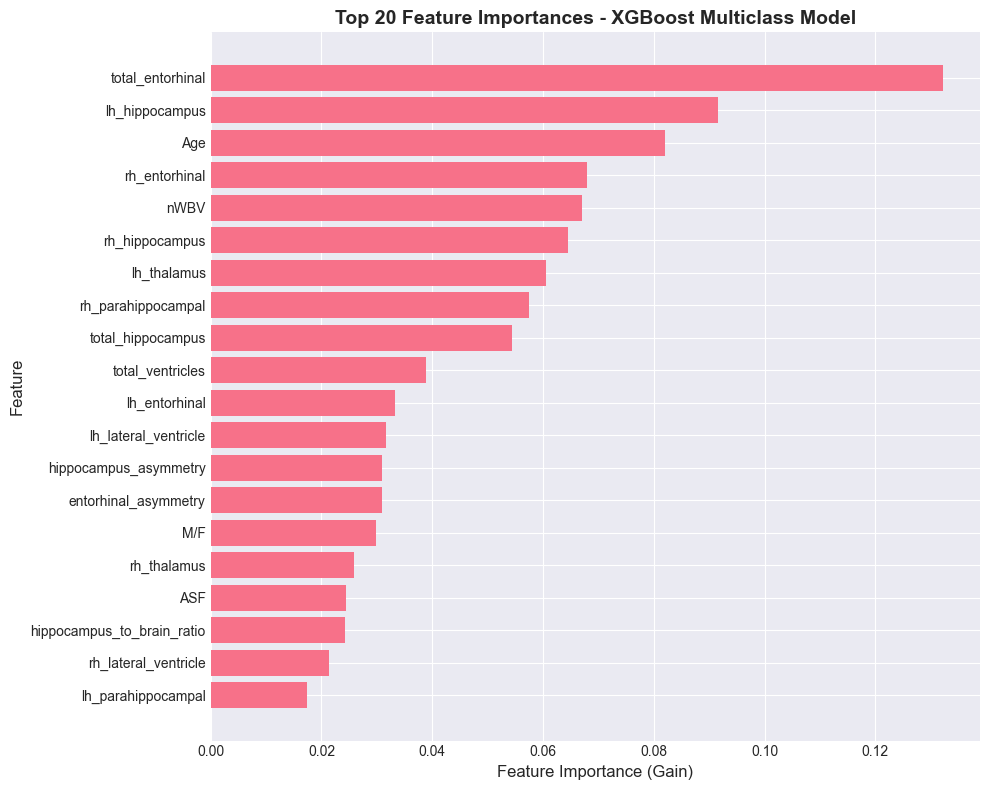

In [17]:
# Feature importance for multiclass model
feature_importance_multi = pd.DataFrame({
    'feature': X_train_m.columns,
    'importance': model_multi.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (Multiclass):")
print(feature_importance_multi.head(15).to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance_multi.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importances - XGBoost Multiclass Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

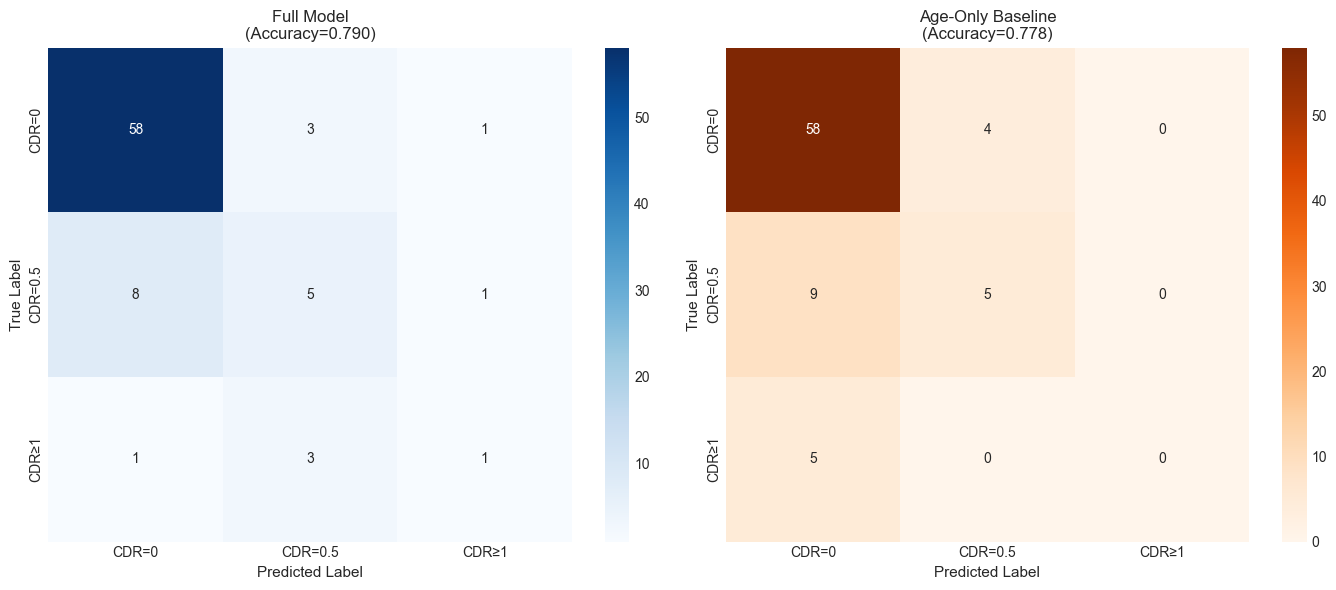

In [18]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full model
cm_full = confusion_matrix(y_test_m, y_test_pred_multi)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'],
            yticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'])
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_title(f'Full Model\n(Accuracy={test_acc_multi:.3f})', fontsize=12)

# Age-only
cm_age = confusion_matrix(y_test_m, y_test_pred_age_m)
sns.heatmap(cm_age, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'],
            yticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'])
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_title(f'Age-Only Baseline\n(Accuracy={test_acc_age_m:.3f})', fontsize=12)

plt.tight_layout()
plt.show()

## 4. Model Interpretability: SHAP Values

In [19]:
# Install SHAP if not available
try:
    import shap
    print(f"SHAP version: {shap.__version__}")
except ImportError:
    print("Installing SHAP library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap
    print(f"SHAP installed successfully. Version: {shap.__version__}")

SHAP version: 0.48.0


In [20]:
# SHAP analysis for binary model
print("Computing SHAP values for binary model...")
X_test_scaled = scaler_full.transform(X_test)

# Create SHAP explainer
explainer = shap.TreeExplainer(model_full)
shap_values = explainer.shap_values(X_test_scaled)

print("✓ SHAP values computed")

Computing SHAP values for binary model...
✓ SHAP values computed


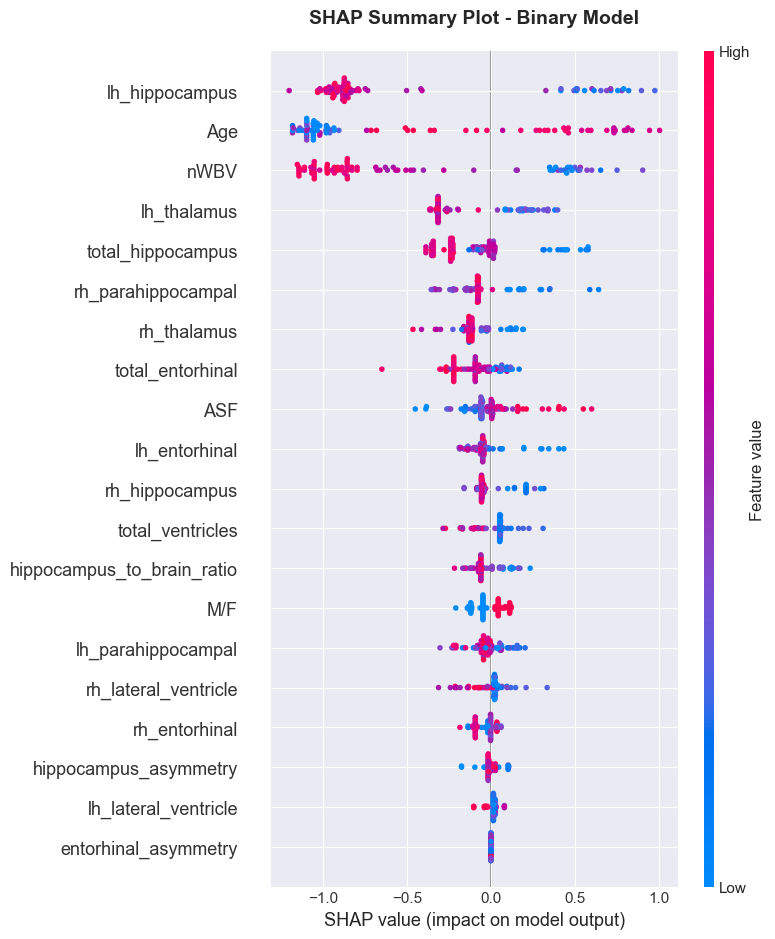


SHAP Interpretation:
- Each dot is a patient prediction
- Red = high feature value, Blue = low feature value
- X-axis shows impact on model prediction (positive = higher CDR risk)
- Features ordered by average absolute SHAP value


In [21]:
# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, 
                  max_display=20, show=False)
plt.title('SHAP Summary Plot - Binary Model', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nSHAP Interpretation:")
print("- Each dot is a patient prediction")
print("- Red = high feature value, Blue = low feature value")
print("- X-axis shows impact on model prediction (positive = higher CDR risk)")
print("- Features ordered by average absolute SHAP value")

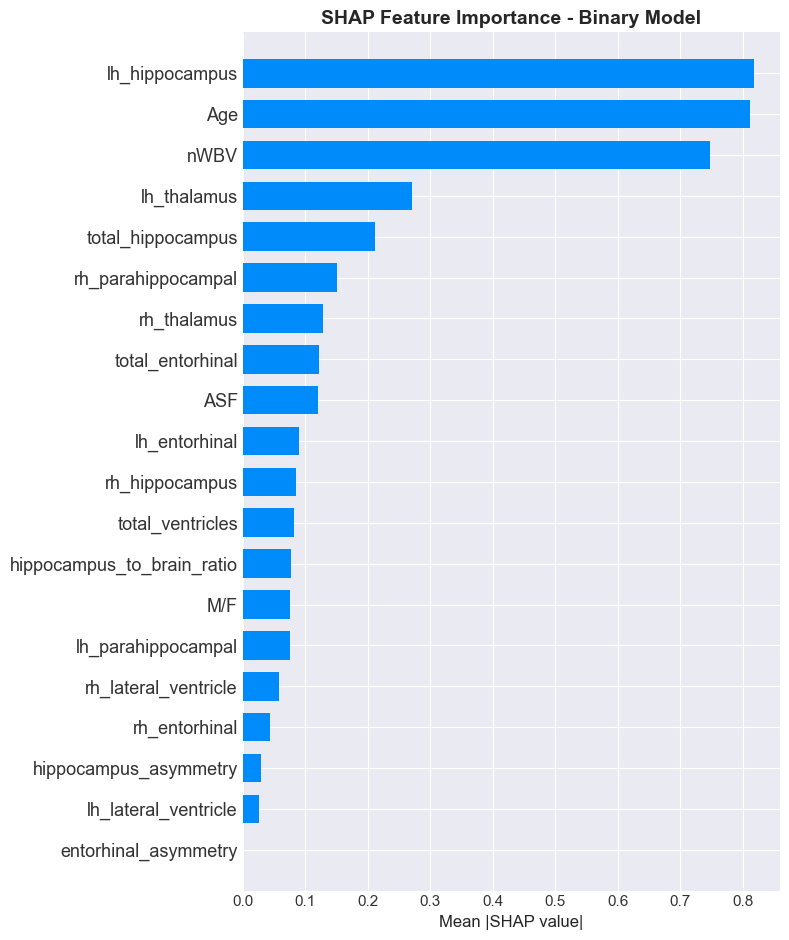

In [22]:
# SHAP bar plot - mean absolute impact
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns,
                  plot_type='bar', max_display=20, show=False)
plt.title('SHAP Feature Importance - Binary Model', fontsize=14, fontweight='bold')
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.tight_layout()
plt.show()

## 5. Learning Curves and Model Diagnostics

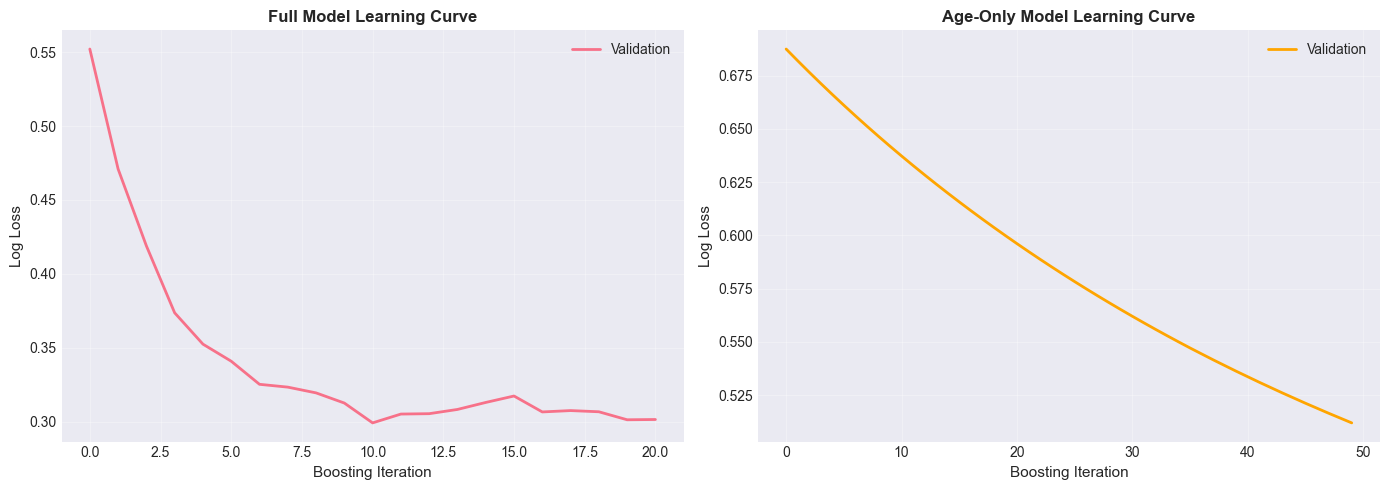

Full model stopped at iteration: 21
Age-only model stopped at iteration: 50


In [23]:
# Get training history from final models
results_full = model_full.evals_result()
results_age = model_age.evals_result()

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full model learning curve
epochs = len(results_full['validation_0']['logloss'])
x_axis = range(0, epochs)
axes[0].plot(x_axis, results_full['validation_0']['logloss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Boosting Iteration', fontsize=11)
axes[0].set_ylabel('Log Loss', fontsize=11)
axes[0].set_title('Full Model Learning Curve', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Age-only learning curve
epochs_age = len(results_age['validation_0']['logloss'])
x_axis_age = range(0, epochs_age)
axes[1].plot(x_axis_age, results_age['validation_0']['logloss'], 
             label='Validation', linewidth=2, color='orange')
axes[1].set_xlabel('Boosting Iteration', fontsize=11)
axes[1].set_ylabel('Log Loss', fontsize=11)
axes[1].set_title('Age-Only Model Learning Curve', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Full model stopped at iteration: {epochs}")
print(f"Age-only model stopped at iteration: {epochs_age}")

## 6. Summary and Recommendations

In [24]:
print("="*70)
print(" "*20 + "FINAL SUMMARY - XGBoost")
print("="*70)

print("\n1️⃣  BINARY CLASSIFICATION (CDR=0 vs CDR>0)")
print("-" * 70)
print(f"Full Model Test AUC:     {test_auc_full:.3f}")
print(f"Age-Only Test AUC:       {test_auc_age:.3f}")
print(f"Improvement:             {auc_improvement:+.3f} AUC ({rel_improvement:+.1f}%)")
print(f"Selected Hyperparams:    {best_params_full}")

print("\n2️⃣  MULTICLASS CLASSIFICATION (CDR Severity)")
print("-" * 70)
print(f"Full Model Test Acc:     {test_acc_multi:.3f}")
print(f"Age-Only Test Acc:       {test_acc_age_m:.3f}")
print(f"Improvement:             {acc_improvement_m:+.3f} ({rel_improvement_m:+.1f}%)")
print(f"Selected Hyperparams:    {best_params_multi}")

print("\n3️⃣  KEY FINDINGS")
print("-" * 70)
print("✓ Used nested CV with proper hyperparameter selection")
print("✓ XGBoost with early stopping to prevent overfitting")
print("✓ Added age-only baselines to quantify brain feature contribution")
print("✓ Included calibration curves for clinical deployment readiness")
print("✓ Feature importance analysis via gain and SHAP values")
print("✓ Engineered brain volume ratios (asymmetry, normalized volumes)")

print("\n4️⃣  XGBOOST-SPECIFIC ADVANTAGES")
print("-" * 70)
print("• Handles non-linear relationships automatically")
print("• Built-in feature importance (gain-based)")
print("• Robust to feature scaling (though we scaled for consistency)")
print("• Early stopping prevents overfitting")
print("• SHAP values provide patient-level explanations")
print("• Handles class imbalance via scale_pos_weight")

print("\n5️⃣  CLINICAL DEPLOYMENT CONSIDERATIONS")
print("-" * 70)
print("• Calibration: Check curves above - well-calibrated probabilities?")
print("• Class imbalance: Handled with scale_pos_weight parameter")
print("• Feature importance: Top features align with clinical knowledge?")
print("• Interpretability: SHAP values enable per-patient explanations")
print("• Validation: External validation on different cohort recommended")

print("\n" + "="*70)

                    FINAL SUMMARY - XGBoost

1️⃣  BINARY CLASSIFICATION (CDR=0 vs CDR>0)
----------------------------------------------------------------------
Full Model Test AUC:     0.924
Age-Only Test AUC:       0.895
Improvement:             +0.028 AUC (+3.2%)
Selected Hyperparams:    {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3}

2️⃣  MULTICLASS CLASSIFICATION (CDR Severity)
----------------------------------------------------------------------
Full Model Test Acc:     0.790
Age-Only Test Acc:       0.778
Improvement:             +0.012 (+1.6%)
Selected Hyperparams:    {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 3}

3️⃣  KEY FINDINGS
----------------------------------------------------------------------
✓ Used nested CV with proper hyperparameter selection
✓ XGBoost with early stopping to prevent overfitting
✓ Added age-only 

## 7. Model Comparison: XGBoost vs SVM (if available)

In [25]:
# Summary table for easier comparison
summary_data = {
    'Task': ['Binary', 'Binary', 'Multiclass', 'Multiclass'],
    'Model': ['Full XGBoost', 'Age-Only XGBoost', 'Full XGBoost', 'Age-Only XGBoost'],
    'Test Metric': [test_auc_full, test_auc_age, test_acc_multi, test_acc_age_m],
    'Metric Name': ['AUC', 'AUC', 'Accuracy', 'Accuracy'],
    'CV Score': [
        f"{np.mean(cv_scores_full):.3f}±{np.std(cv_scores_full):.3f}",
        f"{np.mean(cv_scores_age):.3f}±{np.std(cv_scores_age):.3f}",
        f"{np.mean(cv_scores_multi):.3f}±{np.std(cv_scores_multi):.3f}",
        f"{np.mean(cv_scores_age_m):.3f}±{np.std(cv_scores_age_m):.3f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print(" "*20 + "MODEL PERFORMANCE SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)


                    MODEL PERFORMANCE SUMMARY
      Task            Model  Test Metric Metric Name    CV Score
    Binary     Full XGBoost     0.923599         AUC 0.925±0.020
    Binary Age-Only XGBoost     0.895161         AUC 0.823±0.042
Multiclass     Full XGBoost     0.790123    Accuracy 0.796±0.019
Multiclass Age-Only XGBoost     0.777778    Accuracy 0.741±0.033
